In [1]:
# Requirements: Matplotlib, Numpy, functions_util.py, index.py#, fitting_functions_ZNE.py, h5py

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
#print(os.getcwd())
from index import print_index, get_experiment, index_folder
from functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py


def fit(function, x_axis, y_axis, return_cov=False, p0=[.05,2000000], weights=None):
    # Fit the data to the function
    popt, pcov = curve_fit(function, x_axis, y_axis, p0=p0, sigma=weights, absolute_sigma=True, maxfev=10000)
    
    if return_cov:
        return popt, pcov
    return popt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Usage:
1. Load the data into a folder in the /data/ folder. 
2. Add the name of the folder to "foldername" below
3. Add the name of the experiment to "experiment_name" below, in ascending order of the waiting times
4. Run the code. Enter 'y' to index the folder. Add metadata if you would like
5. The code will produce:
    a. an updated list of values t_w
    b. the amplitude compensation vectors for each of the t_w values


In [2]:
foldername = 'PRE_JIJ_CHECK_CALIBRATION'
experiment_names = ['423','424', '425', '426', '427', '428', '429','430', '431']
t_w_machine_time = [0.000000, 0.119563, 0.358689, 0.717377, 0.956503, 1.195628, 1.793443, 2.391257, 3.586885]
#ids= {558098:0, 558099:, 558100:,558101: 558102: 558103: 558104: 558105:   558106: } #OMEGA_CALIBRATION
#from the foldername, read the data.txt file and return the first line as the experiment names and the second line as the t_w_times
#foldername = 'data/' + foldername



#Fixes the names

index_tf = input('Do you want to index the folder? (y/n): ')
if index_tf == 'y':
    name = input('Enter extra metadata')
    index_folder(foldername, title=name)
else:
    pass    


foldername = 'data/' + foldername

h5_files = [f for f in os.listdir(foldername) if f.endswith('.h5')]

try:
    os.chdir(foldername)
except:
    pass

        

In [3]:

experiment_names = []
t_w_machine_time = []
with open( './data.txt', 'r') as file:
    for line in file:
        if len(experiment_names) == 0:
            experiment_names = line.split(',')
            #replace quotes iwht ''ArithmeticError
            
            #replace ',' with ''
            experiment_names = [name.replace("'", "") for name in experiment_names]
            experiment_names = [name.replace(" ", "") for name in experiment_names]
            experiment_names = [name.replace("\n", "") for name in experiment_names]
        else:
            #replace ',' with ''
            
            t_w_machine_time = line.split(',')
            t_w_machine_time = [float(time) for time in t_w_machine_time]
            

experiment_names = [str(name) for name in experiment_names]
for name_index in range(len(experiment_names)):
    name = experiment_names[name_index]
    if '558' in experiment_names:
        pass
    else:
        name = '558' + name
        experiment_names[name_index] = name
print(experiment_names)
print(t_w_machine_time)

/Users/thomassteckmann/Duke_Analog_ZNE_data/data/PRE_JIJ_CHECK_CALIBRATION
['558423', '558424', '558425', '558426', '558427', '558428', '558429', '558430', '558431']
[0.0, 0.119563, 0.358689, 0.717377, 0.956503, 1.195628, 1.793443, 2.391257, 3.586885]


In [4]:
print()
COUNTS_THRESHOLD = 1

print(os.getcwd())



/Users/thomassteckmann/Duke_Analog_ZNE_data/data/PRE_JIJ_CHECK_CALIBRATION


In [5]:

data_dict = {}
t_w = []
converter = 1/409.6
#print(os.listdir())
for file_name in h5_files:
    file = h5py.File(file_name, 'r')
    #In the file name, add the float after Delay_ and before ms to the list of delays
    #delay = float(file_name.split('-RFSoC')[0])
    #match delay to an element of experiment_names
    for name in experiment_names:
        #print(name)
        if name in file_name:
            #print(name)
            id_index = experiment_names.index(name)
            t_w_current = t_w_machine_time[id_index]*converter*1e3
            break
    #print(file_name)
    t_w.append(t_w_current)
    #delay = ids[delay]
    #t_w.append(delay)
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    x_array = np.asarray(x_vals)
    #Convert counts to probabilities
    #plt.plot(x_array)
    counts = np.asarray(raw_counts)
    raw_counts = np.asarray(raw_counts)
    #print((raw_counts.shape))
    thresholded_counts = raw_counts > COUNTS_THRESHOLD
    probs = np.mean(thresholded_counts, axis=1)
    data = {'x': x_array, 'probs': probs}
    data_dict[t_w_current] = data
    
#sort t_w in ascending order
t_w.sort()
print(t_w)
print(data_dict.keys())

[0.0, 0.29190185546874997, 0.87570556640625, 1.75140869140625, 2.33521240234375, 2.9190136718749997, 4.37852294921875, 5.83802978515625, 8.75704345703125]
dict_keys([8.75704345703125, 0.87570556640625, 5.83802978515625, 0.29190185546874997, 2.33521240234375, 2.9190136718749997, 0.0, 1.75140869140625, 4.37852294921875])


In [6]:
#For each key, extract Omega and theta from the data by fitting to cetina_thermal_exp and cetina_envelope_exp

center_qubit = [-3, -2, -1, 0, 1, 2, 3] 
qubits = data_dict[t_w[0]]['probs'].shape[0]
print(qubits)
#Get the center qubit index:
shift = 0
center_qubit_index = int(qubits/2)+shift
good_qubits = np.array(center_qubit) + center_qubit_index
print(center_qubit_index)
print([i+-12 for i in range(qubits)])
print(good_qubits)
print(center_qubit)
KHz = 1e3
omega =  900*KHz
us = 1e-6
theta = 0.05
thetas = np.zeros((len(t_w), len(good_qubits)))
Omegas = np.zeros((len(t_w), len(good_qubits)))
#For each element of t_w, and each good qubit, curve fit to the data to get Omega and theta
for i, t in enumerate(t_w):
    data = data_dict[t]
    x = data['x']*us
    probs = data['probs']
    for j, q in enumerate(good_qubits):
        #print(j, q)
        popt, pcov = curve_fit(cetina_thermal_exp, x, probs[q, :], p0=[theta, omega])
        theta = popt[0]
        popt, pcov = curve_fit(cetina_envelope_exp, x, probs[q, :], p0=[theta, omega])
        omega = popt[1]
        thetas[i, j] = theta
        Omegas[i, j] = omega
Omega = 1000000


23
11
[-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[ 8  9 10 11 12 13 14]
[-3, -2, -1, 0, 1, 2, 3]


1025694.3276782696 0.06737844517250242


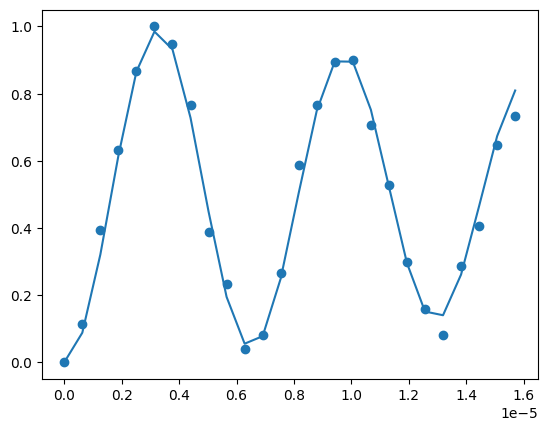

In [7]:
test = data_dict[t_w[1]]
test_x = test['x']*us
test_probs = test['probs'][center_qubit_index, :]
plt.scatter(test_x, test_probs)
popt, pcov = curve_fit(cetina_thermal_exp, test_x, test_probs, p0=[theta, omega])
theta = popt[0]
omega = popt[1]
plt.plot(test_x, cetina_thermal_exp(test_x,theta, omega))
print(omega, theta)

In [8]:
Target_Omega_List = np.zeros(23)
Target_Omega_List[good_qubits] = Omegas[0,:]


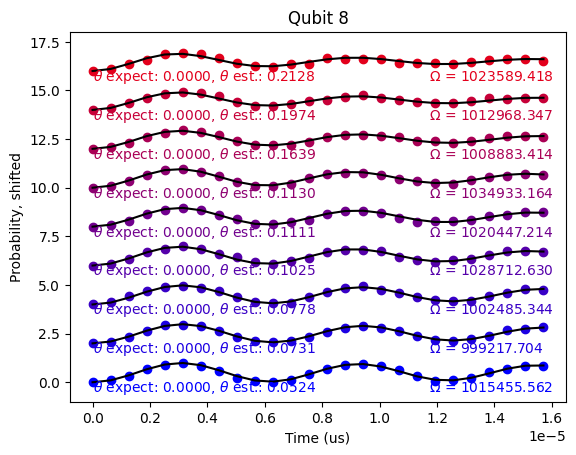

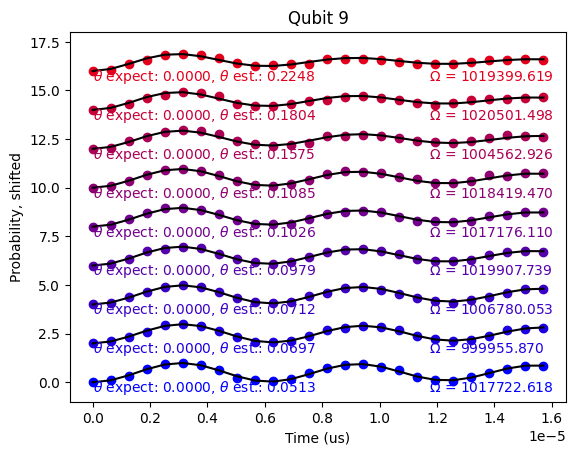

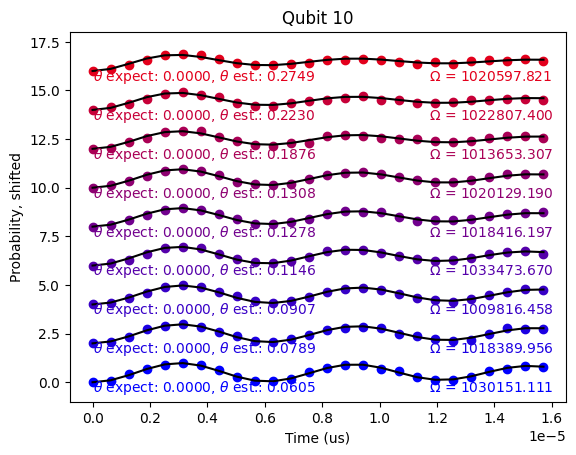

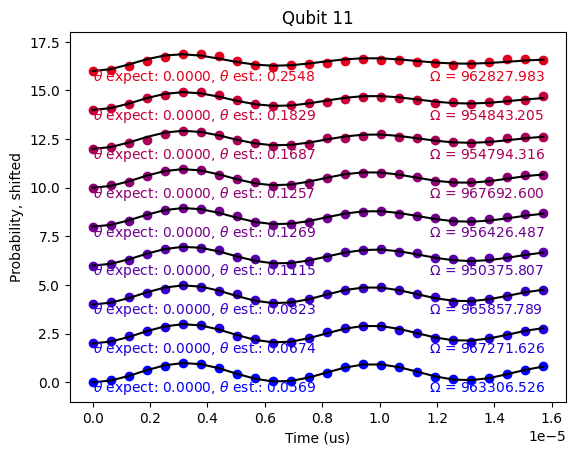

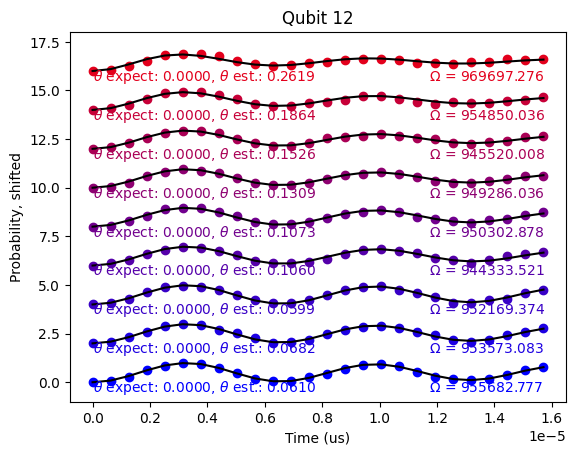

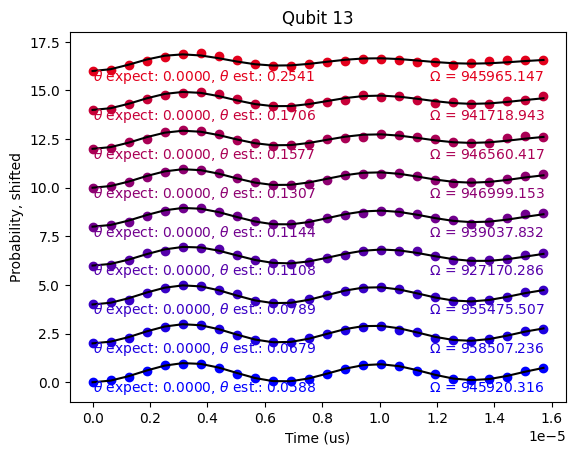

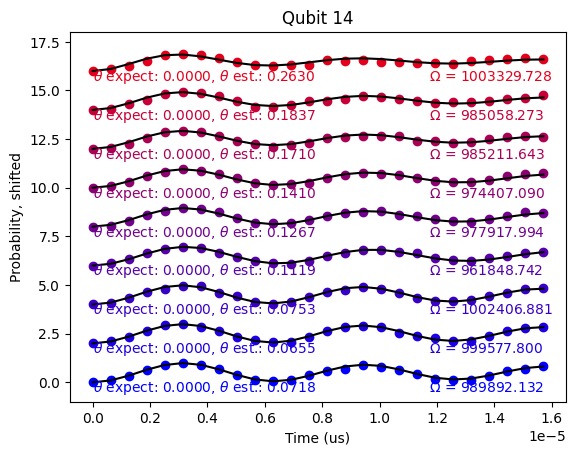

In [9]:
#Computes the scale factors for each Omega and saves plots for each qubit
cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
Omega_scale_factor = np.zeros((len(t_w), len(good_qubits)))
Omegas = np.zeros((len(t_w), len(good_qubits)))
thetas_mat = np.zeros((len(t_w), len(good_qubits)))
for i in range(len(good_qubits)):
    qubit = good_qubits[i]
    fig = plt.figure()
    for Omega_index in range(len(t_w)):
        t_w_data = data_dict[t_w[Omega_index]]
        x = t_w_data['x']*us
        y = t_w_data['probs'][qubit]
        # Get the color for the current plotfga
        color = cmap(Omega_index / len(t_w))
        fit_output = fit(cetina_thermal_exp, x, y, p0=[.01, Omega])

        theta_fit = fit_output[0]
        fit_output = fit(cetina_envelope_exp, x, y, p0=[.01, Omega])

        Omega_fit = fit_output[1]
        
        plt.plot(x, y + Omega_index*2, 'o', color=color, label='Experimental Data') 
        plt.plot(x, cetina_envelope_exp(x, *fit_output) + Omega_index*2, color='k', label='Fit') 
        plt.text(0, Omega_index*2 - 0.5, r'$\theta$ expect: {:.4f}, $\theta$ est.: {:.4f}'.format(0, theta_fit), color=color)
        plt.text(max(x)-4*us, Omega_index*2 - 0.5, r'$\Omega$ = {:.3f}'.format(Omega_fit), color=color)
        Omegas[Omega_index, i] = Omega_fit
        Omega_scale_factor[Omega_index,i] = Target_Omega_List[qubit]/Omega_fit
        thetas_mat[Omega_index,i] = theta_fit
    plt.xlabel('Time (us)')
    plt.ylabel('Probability, shifted')
    plt.title('Qubit {}'.format(qubit))
    plt.ylim(-1, 2*len(t_w))
    plt.savefig('Qubit_{}'.format(qubit))
    #plt.show()
cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])

Qubit 8: Theta slope: 0.019132033956866894
Qubit 9: Theta slope: 0.019910412374257502
Qubit 10: Theta slope: 0.02466693570546047
Qubit 11: Theta slope: 0.02180374243554679
Qubit 12: Theta slope: 0.023046951007766575
Qubit 13: Theta slope: 0.021117683657200997
Qubit 14: Theta slope: 0.022190343835205885
/Users/thomassteckmann/Duke_Analog_ZNE_data/data/PRE_JIJ_CHECK_CALIBRATION


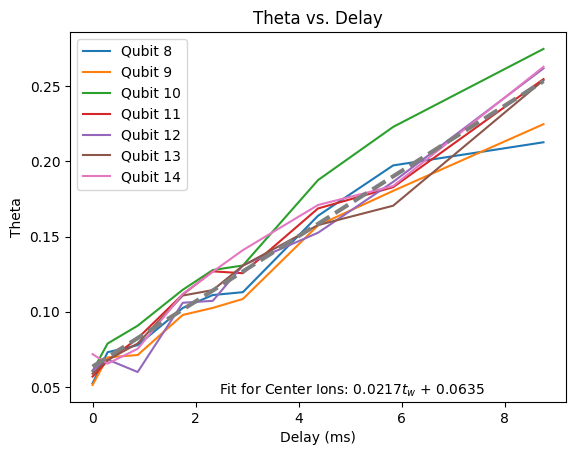

In [10]:
#Extracts the heating rate for each qubit
plt.figure()
for i in range(len(good_qubits)):
    plt.plot(t_w, thetas_mat[:, i], label='Qubit {}'.format(good_qubits[i]))
plt.xlabel('Delay (ms)')
plt.ylabel('Theta')
plt.legend()
plt.title('Theta vs. Delay')
#Extract the average of the thetas slope. Fit each qubit to a line and extract the slope, then average
thetas_slopes = np.zeros(len(good_qubits))
intercepts = np.zeros(len(good_qubits))
for i in range(len(good_qubits)):
    popt, pcov = np.polyfit(t_w, thetas_mat[:, i], 1, cov=True)
    thetas_slopes[i] = popt[0]
    intercepts[i] = popt[1]
    print('Qubit {}: Theta slope: {}'.format(good_qubits[i], popt[0]))
thetas_slope = np.mean(thetas_slopes)
intercept = np.mean(intercepts)
plt.plot(t_w, thetas_slope*np.array(t_w) + intercept, label='Average Theta Slope', linestyle='--', lw=3)
#Add text with the average theta slope and intercept:
plt.text(0.3, 0.02, r'Fit for Center Ions: {:.4f}$t_w$ + {:.4f}'.format(thetas_slope, intercept), transform=plt.gca().transAxes)
#save the plot:
print(os.getcwd())
plt.savefig('Theta_vs_Delay.png', dpi=600)
plt.show()
#print()

In [11]:
#Compute Updated t_w times:
target_thetas = [1, 1.1, 1.3, 1.6, 1.8, 2, 2.5, 3, 4]
#Using theta_slop and intercept, compute the updated wait times so that target_thetas*thetas_intercept = tw*thetas_slope + thetas_intercept
updated_t_w = (np.array(target_thetas)*intercept - intercept)/thetas_slope
updated_thetas = thetas_slope*updated_t_w + intercept
with open('Updated_Delay.txt', 'w') as f:
    f.write('gamma,\tUpdated_Delay(ms)\n')
    for i in range(len(updated_t_w)):
        f.write('{},\t{}\n'.format(target_thetas[i], updated_t_w[i]))
    f.write('\n')
    f.write('Theta Slope: {}\n'.format(thetas_slope))
    f.write('Intercept: {}\n'.format(intercept))
    
export_info = ''
export_info += 'Updated times in ms:\n'
print('Updated times in ms:')

build_string = '['
for item in range(len(updated_t_w)):
    build_string += '{:.6f}'.format(updated_t_w[item])
    if item != len(updated_t_w)-1:
        build_string += ', '
build_string += ']'
print(build_string)
export_info += build_string + '\n'

print('Updated times in machine time:')
export_info += 'Updated times in machine time:\n'
build_string = '['

for item in range(len(updated_t_w)):
    build_string += '{:.6f}'.format(updated_t_w[item]/1e3 /converter)
    if item != len(updated_t_w)-1:
        build_string += ', '
build_string += ']'
print(build_string)
export_info += build_string + '\n'

#print(print('[' + ", ".join(map(str, updated_t_w/1e3 /converter)) + ']'))
#export_info +='[' + ", ".join(map(str, updated_t_w/1e3 /converter)) + ']\n'



Updated times in ms:
[0.000000, 0.292580, 0.877741, 1.755482, 2.340642, 2.925803, 4.388704, 5.851605, 8.777408]
Updated times in machine time:
[0.000000, 0.119841, 0.359523, 0.719045, 0.958727, 1.198409, 1.797613, 2.396818, 3.595226]


In [12]:
print(updated_t_w)
print(updated_thetas/intercept)

[0.         0.29258026 0.87774079 1.75548158 2.3406421  2.92580263
 4.38870394 5.85160525 8.77740788]
[1.  1.1 1.3 1.6 1.8 2.  2.5 3.  4. ]


collective fit:
-0.007478295079995201
1.0042183120268158
[0.0513144  0.05238813 0.05686295 0.05883234 0.0599151  0.06050254
 0.06097265 0.06547415 0.06737845 0.06789447 0.0681791  0.06966615
 0.07121106 0.07179207 0.07308641 0.07533445 0.07777521 0.07886068
 0.07890002 0.082292   0.09070905 0.09788567 0.1025278  0.10257714
 0.10597778 0.10728594 0.10850097 0.11080562 0.11112738 0.1115242
 0.11186335 0.11303465 0.11440842 0.11464385 0.1256562  0.12665465
 0.12688359 0.12777043 0.13067517 0.1307915  0.13090559 0.14100633
 0.15257888 0.15748102 0.15767244 0.16387482 0.16874722 0.17058099
 0.17103561 0.18044418 0.18293119 0.1837126  0.18644654 0.18762307
 0.19739185 0.21278445 0.22301853 0.22482478 0.25409926 0.2548209
 0.26194874 0.26298889 0.27491018]
Average:
-0.013351342126010175
1.0048285528263234


Text(0, 0.5, 'Omega Compensation Factor')

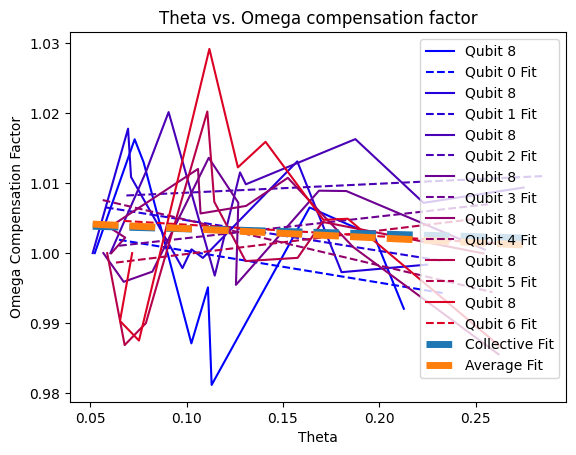

In [13]:

#fit to a line:
def line(x, m, b):
    return x*m  + b
mb_mat = np.zeros((len(good_qubits), 2))
Omega_comp_fit_matrix = np.zeros(Omega_scale_factor.shape)
m_list = []
b_list = []
for qubit_index in range(len(good_qubits)):
    #pick a color from the cmap:
    color = cmap(qubit_index/len(good_qubits))
    plt.plot(thetas_mat[:, qubit_index], Omega_scale_factor[:,qubit_index], label='Qubit {}'.format(i), color=color)
    popt, pcov = curve_fit(line, thetas_mat[:,qubit_index], Omega_scale_factor[:,qubit_index])
    m = popt[0]
    b = popt[1]
    m_list.append(m)
    b_list.append(b)
    
    #b = 1- thetas[0,qubit_index]*m
    #print(m*thetas[:,qubit_index] + b)
    #Compute the expected theta values for each qubit at the new wait times:
    theta_slope_qubit = thetas_slopes[qubit_index]
    theta_intercept_qubit = intercepts[qubit_index]
    new_thetas = theta_slope_qubit*updated_t_w + theta_intercept_qubit
    #Compute the new compensations for each qubit and wait time:
    Omega_comp_fit = line(new_thetas, m, b)
    Omega_comp_fit_matrix[:,qubit_index] = Omega_comp_fit 
    plt.plot(new_thetas, Omega_comp_fit, label='Qubit {} Fit'.format(qubit_index), color=color, linestyle='--')   
popt, pcov = curve_fit(line, thetas_mat.flatten(), Omega_scale_factor.flatten())
print('collective fit:')
m_collective = popt[0]
b_collective = popt[1]
print(m_collective)
print(b_collective)
flatten_theta = thetas_mat.flatten()
flatten_theta.sort()
print(flatten_theta)
plt.plot(flatten_theta, line(flatten_theta, m_collective, b_collective),  label='Collective Fit', linestyle='--', lw=5)#, label='')
print('Average:')
print(np.average(m_list))
average_m = np.average(m_list)
print(np.average(b_list))
average_b = np.average(b_list)
plt.plot(flatten_theta, line(flatten_theta, average_m, average_b), label='Average Fit', linestyle='--', lw=5)#, label='')
plt.legend()

#Compute the Omega_comp matrix for the updated times:
Omega_comp_fit_matrix = np.zeros(Omega_scale_factor.shape)
for i in range(len(good_qubits)):
    Omega_comp_fit_matrix[:,i] = line(updated_thetas, average_m, average_b)
Omega_old_comp = np.zeros(Omega_scale_factor.shape)
for i in range(len(good_qubits)):
    Omega_old_comp[:,i] = line(np.array(t_w)*thetas_slope + intercept, average_m, average_b)


plt.title('Theta vs. Omega compensation factor')
plt.xlabel('Theta')
plt.ylabel('Omega Compensation Factor')
#Compute Updated Omega_comp from the fits


In [14]:

for i in range(len(t_w)):
    #print('t_w:{:.6f} ms '.format(updated_t_w[i]))
    print('t_w:{:.6f} machine time '.format(updated_t_w[i]*1e-3*409.6))
    #replace each '  ' with ' '
    #print('[' + ", ".join(map(str, Omega_comp_fit_matrix[i])) + ']')
    print(Omega_comp_fit_matrix[i,0])
    export_info +='t_w:{:.6f} ms \n'.format(updated_t_w[i])
    export_info +='t_w:{:.6f} machine time \n'.format(updated_t_w[i]*1e-3*409.6)
    export_info += str(Omega_comp_fit_matrix[i,0]) + '\n'
    #export_info +='[' + ", ".join(map(str, Omega_comp_fit_matrix[i])) + ']\n'
#Save export_info to a .txt file called 'Udpated parameters:'
with open('Updated_parameters.txt', 'w') as f:
    f.write(export_info)

    

t_w:0.000000 machine time 
1.0039810552236514
t_w:0.119841 machine time 
1.0038963054633843
t_w:0.359523 machine time 
1.0037268059428497
t_w:0.719045 machine time 
1.0034725566620482
t_w:0.958727 machine time 
1.0033030571415138
t_w:1.198409 machine time 
1.0031335576209792
t_w:1.797613 machine time 
1.0027098088196433
t_w:2.396818 machine time 
1.0022860600183072
t_w:3.595226 machine time 
1.0014385624156352


In [15]:
print(t_w)

[0.0, 0.29190185546874997, 0.87570556640625, 1.75140869140625, 2.33521240234375, 2.9190136718749997, 4.37852294921875, 5.83802978515625, 8.75704345703125]


In [16]:
#Export to a text file:


Theta values:
[0.06347658 0.06980953 0.08247541 0.10147417 0.11414005 0.12680588
 0.15847058 0.19013523 0.25346452]


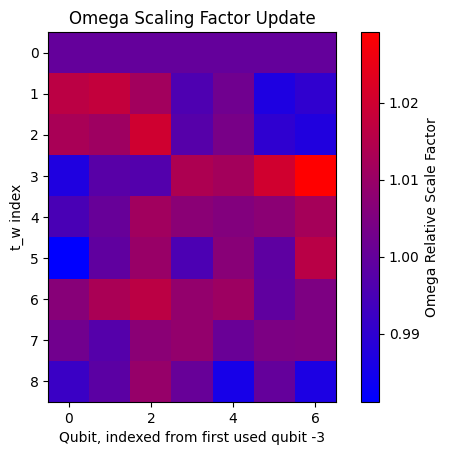

In [17]:
plt.imshow(Omega_scale_factor, cmap=cmap)
plt.xlabel('Qubit, indexed from first used qubit {}'.format(center_qubit[0]+ shift))
plt.ylabel('t_w index')
plt.title('Omega Scaling Factor Update')
cbar = plt.colorbar()
cbar.set_label('Omega Relative Scale Factor')
plt.savefig('Omega_Scale_Factor_raw.png', dpi=600)
print('Theta values:')
print(np.array(t_w)*thetas_slope + intercept)

[0.06347658 0.06982424 0.08251956 0.10156254 0.11425785 0.12695317
 0.15869146 0.19042975 0.25390634]


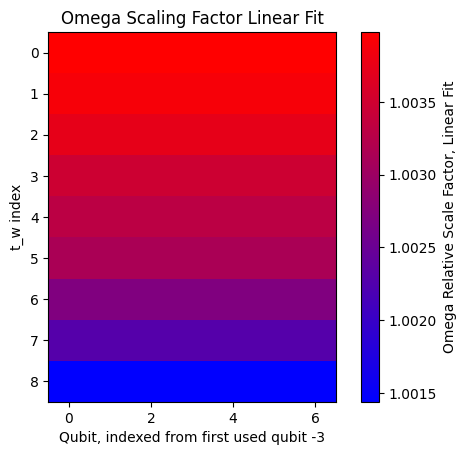

In [18]:
plt.imshow(Omega_comp_fit_matrix, cmap=cmap)
plt.xlabel('Qubit, indexed from first used qubit {}'.format(center_qubit[0]+ shift))
plt.ylabel('t_w index')
plt.title('Omega Scaling Factor Linear Fit')
cbar = plt.colorbar()
cbar.set_label('Omega Relative Scale Factor, Linear Fit')
plt.savefig('Omega_Scale_Factor_fit.png', dpi=600)
print(updated_thetas)

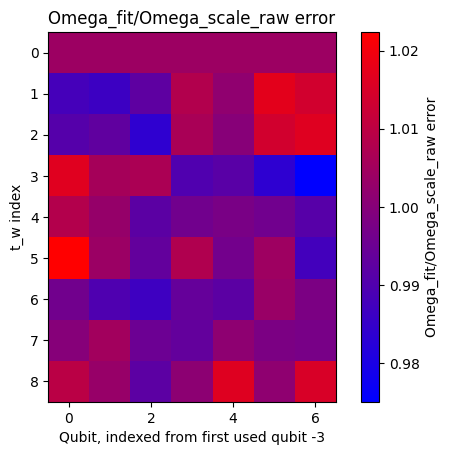

In [19]:
plt.imshow(Omega_comp_fit_matrix/Omega_scale_factor, cmap=cmap)
plt.xlabel('Qubit, indexed from first used qubit {}'.format(center_qubit[0]+ shift))
plt.ylabel('t_w index')
plt.title('Omega_fit/Omega_scale_raw error')
cbar = plt.colorbar()
cbar.set_label('Omega_fit/Omega_scale_raw error')
plt.savefig('Omega_fitoverOmega_scale_raw error.png', dpi=600)


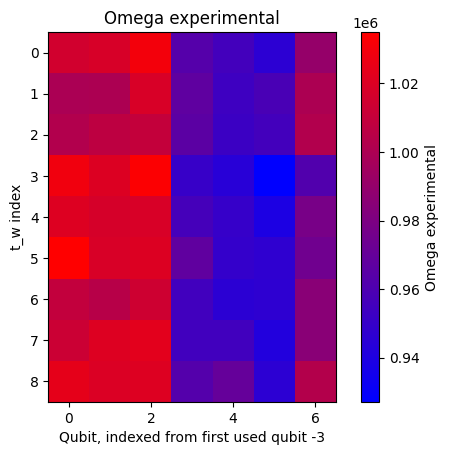

In [20]:
plt.imshow(Omegas, cmap=cmap)
plt.xlabel('Qubit, indexed from first used qubit {}'.format(center_qubit[0]+ shift))
plt.ylabel('t_w index')
plt.title('Omega experimental')
cbar = plt.colorbar()
cbar.set_label('Omega experimental')
plt.savefig('Omega_experimental.png', dpi=600)


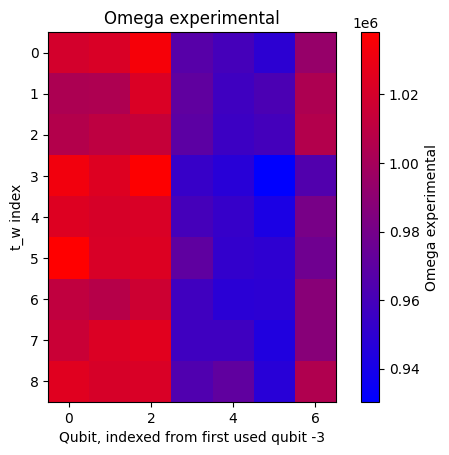

In [21]:
plt.imshow(Omegas*Omega_old_comp, cmap=cmap)
plt.xlabel('Qubit, indexed from first used qubit {}'.format(center_qubit[0]+ shift))
plt.ylabel('t_w index')
plt.title('Omega experimental')
cbar = plt.colorbar()
cbar.set_label('Omega experimental')
#plt.savefig('Omega_experimental.png', dpi=600)


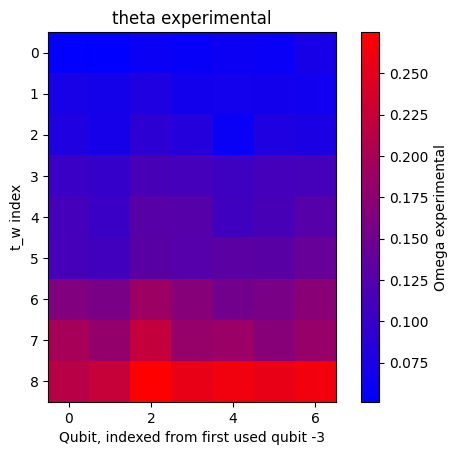

In [22]:
plt.imshow(thetas_mat, cmap=cmap)
plt.xlabel('Qubit, indexed from first used qubit {}'.format(center_qubit[0]+ shift))
plt.ylabel('t_w index')
plt.title('theta experimental')
cbar = plt.colorbar()
cbar.set_label('Omega experimental')
plt.savefig('theta_experimental.png', dpi=600)


In [23]:
from functions_util import gaussian_envelope_shifted, cetina_thermal, gaussian_envelope, generate_experimental_data, rabi_flop_gauss_fit, rabi_flop_gauss_fit_shifted, cetina_thermal_exp,cetina_envelope
from fitting_functions_ZNE import log_fit_exp_ZNE, gaussian_ZNE, cubic_ZNE, linear_ZNE, Cetina_fit, exp_ZNE, third_no_first_ZNE, quadratic_only_ZNE


In [24]:
def save_plot(qubit_index):
    """Make a plot with the shape
    |----|----|----|
    |    |    |    |
    |----|----|----|
    |              |
    |--------------|
    Which is 3 small plots over one long plot. So a 3x2 grid, but the lower plots are merged
    """
    thetas = intercept + np.array(t_w)*thetas_slope
    thetas = thetas_mat[:, qubit_index]
    
    print('Average:')
    print(np.average(Omegas[:,qubit_index]))
    average_Omega = np.average(Omegas[:,qubit_index])
    print(Omegas[:,qubit_index])
    print('Target:')
    print(Target_Omega_List[qubit_index])
    trim = -2
    if trim == 0:
        trim = len(thetas)
    
    thetas = thetas[:trim]
    t_w_temp = t_w[:trim]
    n = len(t_w_temp)
    print(n)
    for i in range(n):
        t_w_index = t_w[i]
        t_w_data = data_dict[t_w_index]
        times = t_w_data['x']*us
        raw_data = t_w_data['probs'][qubit_index]
    data = np.zeros((n, len(times)))
    for i in range(n):
        t_w_index = t_w[i]
        t_w_data = data_dict[t_w_index]
        times = t_w_data['x']*us
        raw_data = t_w_data['probs'][qubit_index]
        data[i, :] = raw_data
    fig = plt.figure()
    ax2 = fig.add_subplot(332)
    ax1 = fig.add_subplot(331, sharex=ax2)
    ax3 = fig.add_subplot(333, sharex=ax2)
    dense_theta = np.linspace(0, max(thetas), 1000)
    #ax1.set_xlim(min(dense_theta), .15)
    #ax2.yaxis.set_visible(False)
    #ax3.yaxis.set_visible(False)

    ax4 = fig.add_subplot(312)
    #ax1.set_xlim(-0.02, max(thetas)+0.02)
    max_time = max(times)
    marked_times = np.linspace(0, max_time, 4, endpoint=False)[1:]
    marked_times[2] = marked_times[2] + 1e-6
    marked_times[0] = marked_times[0] - 1e-6
    
    index_baseline = 0
    ax4.vlines(marked_times, -4, 4, color='black', linestyle='--')
    for i in range(n):
        if i >= index_baseline:
            pass
        else:
            #go to next iteration
            continue
        color = cmap((i-index_baseline) / (n-index_baseline))
        ax4.plot(times, data[i, :].T, color=color, alpha=0.4)
        ax4.fill_between(times, data[i, :], data[i, :], color=color, alpha=0.2)
    #good_data = generate_experimental_data(times, Target_Omega_List[qubit_index], np.array([0.]), 1000)
    #good_data = 0.5 - (good_data/ 2)
    good_data = cetina_thermal_exp(times, 0, Target_Omega_List[qubit_index])
    ax4.plot(times, good_data, color='black', label='Ideal Data')
    #ax4.plot(times, generate_experimental_data(times, 1, np.array([0.]), 1000), color='black', label='Ideal Data')
    ax4.set_ylim(-0.3, 1.3)



    function_colors = ['purple', 'orange', 'blue', 'brown']
    fit_functions = [linear_ZNE, cubic_ZNE, log_fit_exp_ZNE]
    function_names = ['Linear', 'Cubic', 'Exponential']

    function_colors = ['orange', 'green', 'brown']
    fit_functions = [linear_ZNE, third_no_first_ZNE]
    function_names = ['Linear Extrapolation', 'Cubic']


    axes = [ax1, ax2, ax3]



    for t_i in range(len(marked_times)):
        #Take the data slice at the time:
        axis = axes[t_i]
        #Get the nearest index in time to the marked time:
        time_i = np.argmin(np.abs(times - marked_times[t_i]))
        time = times[time_i]
        print(time_i)
        vs_theta = data[:,time_i]
        axis.errorbar(thetas[:index_baseline], vs_theta[:index_baseline],  fmt='o', label='Experimental Data')
        #Baseline
        axis.errorbar(thetas[index_baseline], vs_theta[index_baseline], fmt='o', label='Experimental Data')
        if t_i == 0:
            axis.vlines(thetas[index_baseline], min(vs_theta)+0.04, max(vs_theta),color='black', linestyle='--')#, label='Experimental Limit'
            axis.text(thetas[index_baseline]-0.02, min(vs_theta), 'Experimental Limit', color='black')
        #Right of baseline:
        axis.errorbar(thetas[index_baseline+1:], vs_theta[index_baseline+1:], fmt='o', label='Experimental Data')
        axis.scatter(0, good_data[time_i])
        for f_i in range(len(fit_functions)):
            fit_function = fit_functions[f_i]
            fit_line = fit_function(thetas[index_baseline:], vs_theta[index_baseline:])
            axis.plot(dense_theta, fit_line(dense_theta), color=function_colors[f_i], label=function_names[f_i])

        #Plot expected from Cetina:
        #func_cetina = lambda x: 1/np.sqrt(1 + (target_Omega*time*x)**2)*np.cos(target_Omega*time)# - np.arctan(target_Omega*time*x))
        #axis.plot(dense_theta, func_cetina(dense_theta), color='green', label='Cetina')
        axis.set_title('Time: {:.2f}'.format(time))
        axis.set_ylabel('Population Transfer')


    ax2.set_xlabel(r'Measured $\theta$')
    fitted_values = np.zeros((len(times), len(fit_functions)))
    for t_i in range(len(times)):
        time_slice = data[:,t_i]
        for f_i in range(len(fit_functions)):
            fit_function = fit_functions[f_i]
            fit_line = fit_function(thetas[index_baseline:], time_slice[index_baseline:])
            fitted_values[t_i, f_i] = fit_line(0)
            #ax4.plot(dense_theta, fit_line(dense_theta), color=function_colors[f_i], label=function_names[f_i])

    for f_i in range(len(fit_functions)):
        ax4.plot(times, fitted_values[:,f_i], color=function_colors[f_i], label=function_names[f_i])

    #ax4.plot(times, full_ZNE_fancy_exp, color='brown', label='Fancy Exponential Fit')
    fig.set_size_inches(10,8)
    fig.suptitle(r'ZNE for Frequency Corrected Rabi Flopping, $\Omega = 1$')
    fig.tight_layout()

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(thetas)))
    sm.set_array([])
    #Add a label to the color bar:

    cbar = fig.colorbar(sm, ax=ax4)

    cbar.set_label(r'$\theta$')


    # save = input('Save Figure? (y/n)')
    # if save == 'y':
    #     metadata = input('Please provide some metadata for the figure:')
    #     #Strip spaces and illegal save characters:
    #     metadata = metadata.replace(' ', '_')
    #     metadata = metadata.replace('/', '_')
    #     metadata = metadata.replace('\\', '_')
    #     plt.savefig('ZNE_Fit_Rabi_data_{}.png'.format(metadata), dpi = 600)
        #plt.savefig('ZNE_Fit_Rabi_data.png', dpi = 600)
    #Add the color bar to axis 4:
    #fig.colorbar()
    plt.savefig('Extrapolation_Test_Qubit_{}'.format(qubit_index), dpi=600)
    plt.show()
    


    #ax4 = fig.add_subplot(313)

In [29]:
os.chdir('~/')

FileNotFoundError: [Errno 2] No such file or directory: '~/'

Average:
1016299.1996590348
[1015455.56241193  999217.70404552 1002485.34407188 1028712.63026469
 1020447.21399841 1034933.16367474 1008883.41392942 1012968.34651625
 1023589.41801847]
Target:
0.0
7
5
12
20


/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


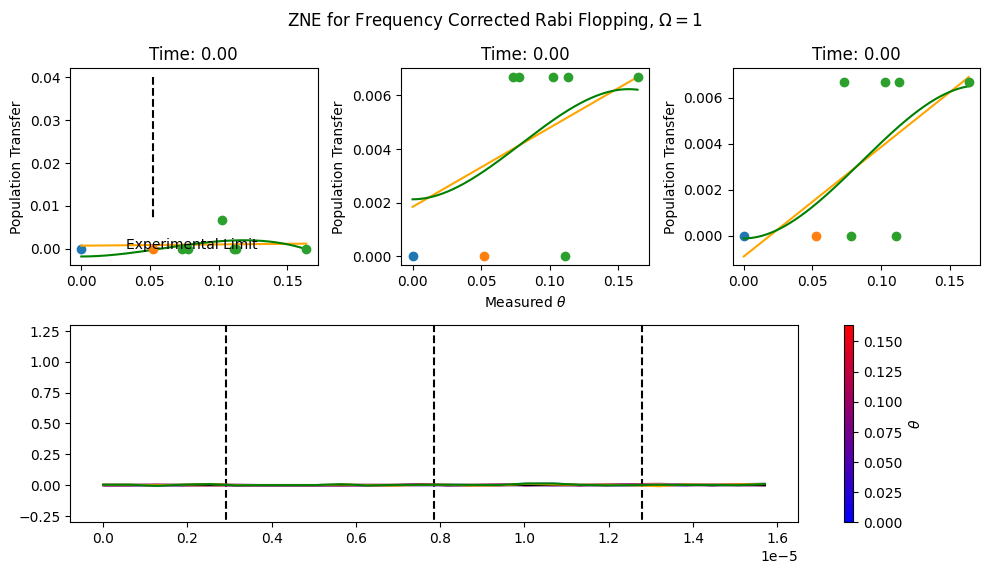

Average:
1013825.1002832262
[1017722.6180071   999955.86954703 1006780.05306839 1019907.73850843
 1017176.10951173 1018419.4701076  1004562.92638449 1020501.49815629
 1019399.61925798]
Target:
0.0
7
5
12
20


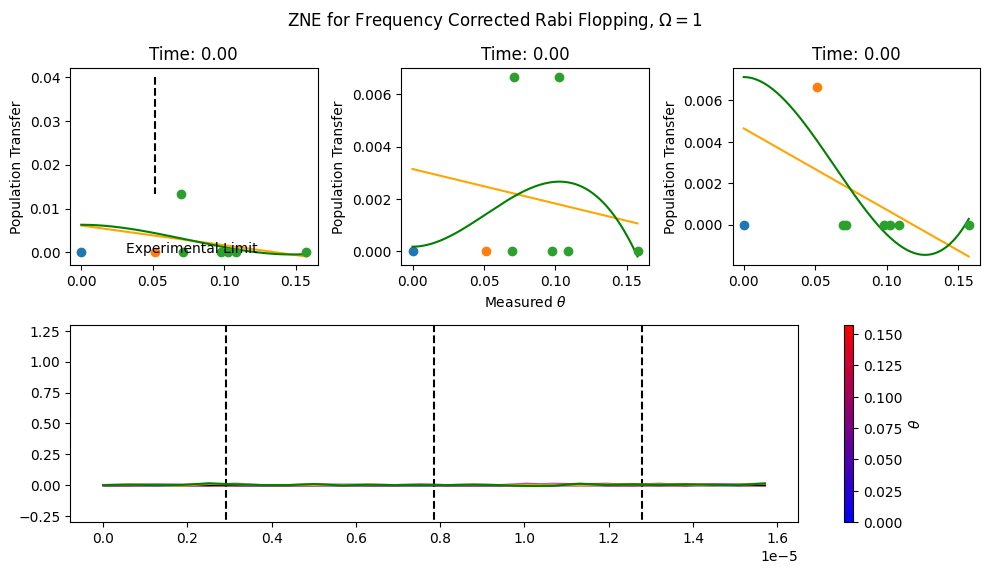

Average:
1020826.123296112
[1030151.11053057 1018389.95586179 1009816.45826977 1033473.67047932
 1018416.19652646 1020129.18967669 1013653.30725922 1022807.39960948
 1020597.82145171]
Target:
0.0
7
5
12
20


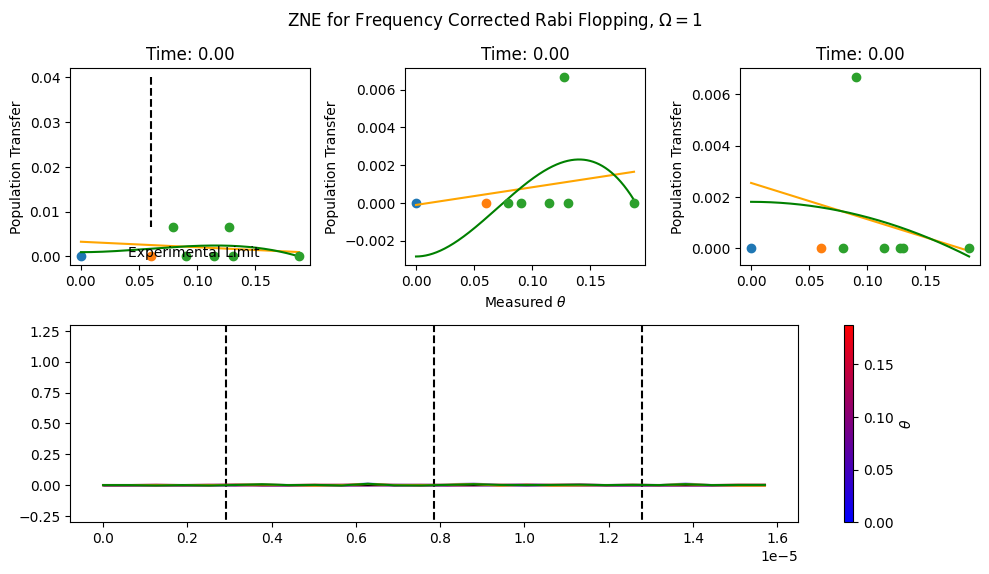

Average:
960377.3710734
[963306.52646929 967271.62586807 965857.78921538 950375.80674545
 956426.48749884 967692.60016665 954794.31619821 954843.20470499
 962827.98279372]
Target:
0.0
7
5
12
20


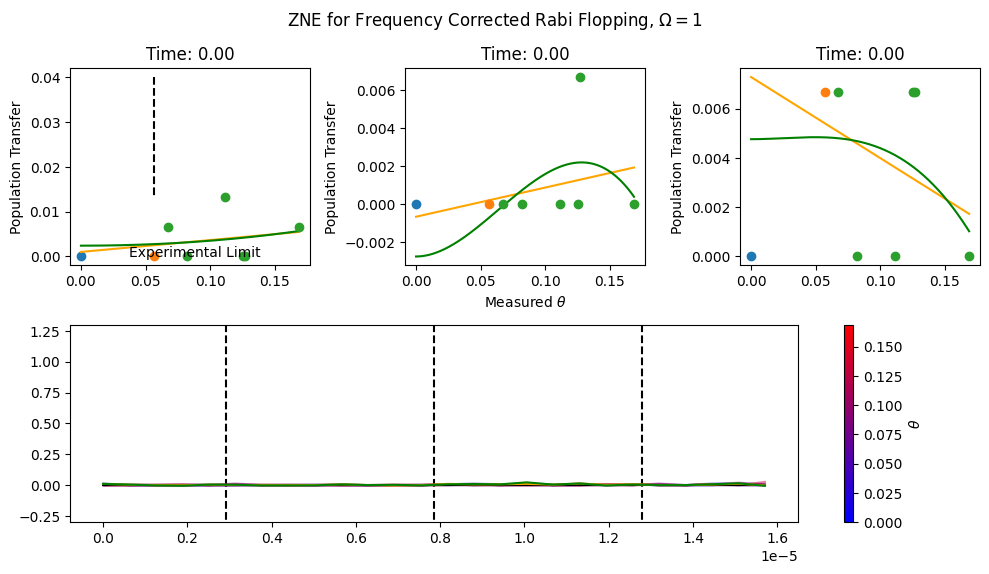

Average:
952823.887798247
[955682.7768624  953573.08296723 952169.3739331  944333.52128201
 950302.87836295 949286.03602301 945520.00836156 954850.03624417
 969697.2761478 ]
Target:
0.0
7
5
12
20


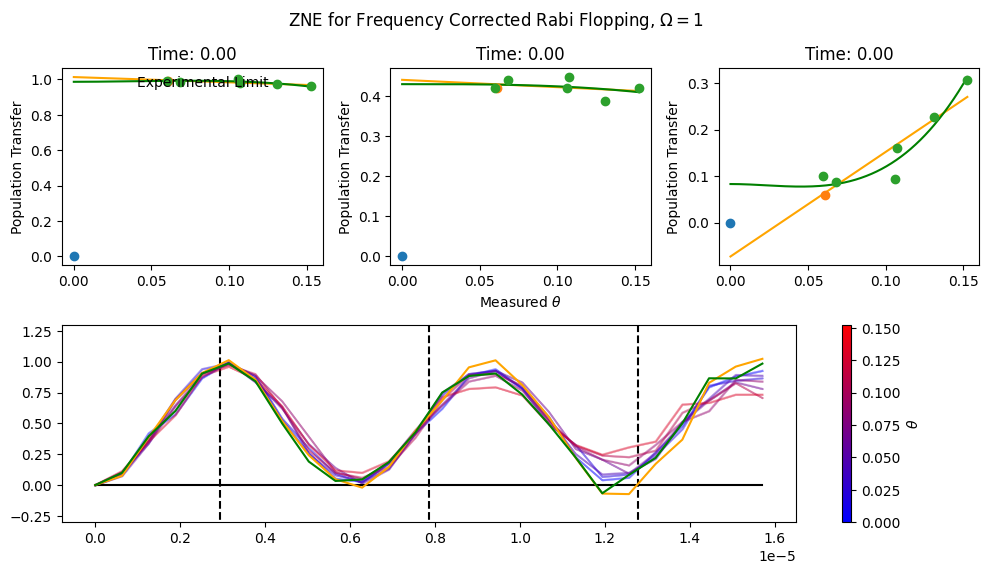

Average:
945261.6484632
[945920.3156794  958507.23562639 955475.50732607 927170.28608367
 939037.83176667 946999.15266956 946560.41689362 941718.94284229
 945965.14728115]
Target:
0.0
7
5
12
20


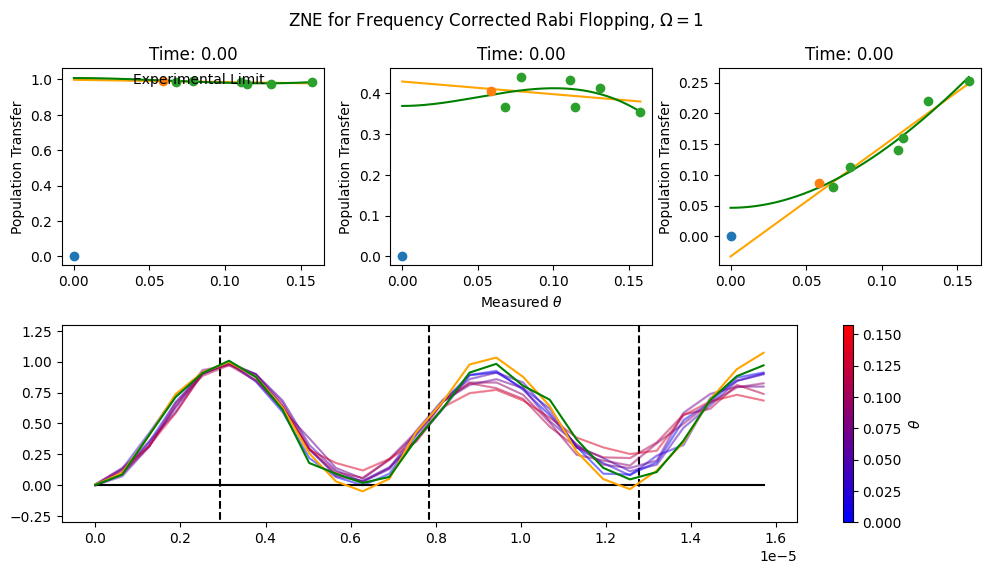

Average:
986627.8090470607
[ 989892.13179138  999577.79978407 1002406.88112481  961848.74165097
  977917.99393428  974407.089643    985211.64279627  985058.27280429
 1003329.72789448]
Target:
0.0
7
5
12
20


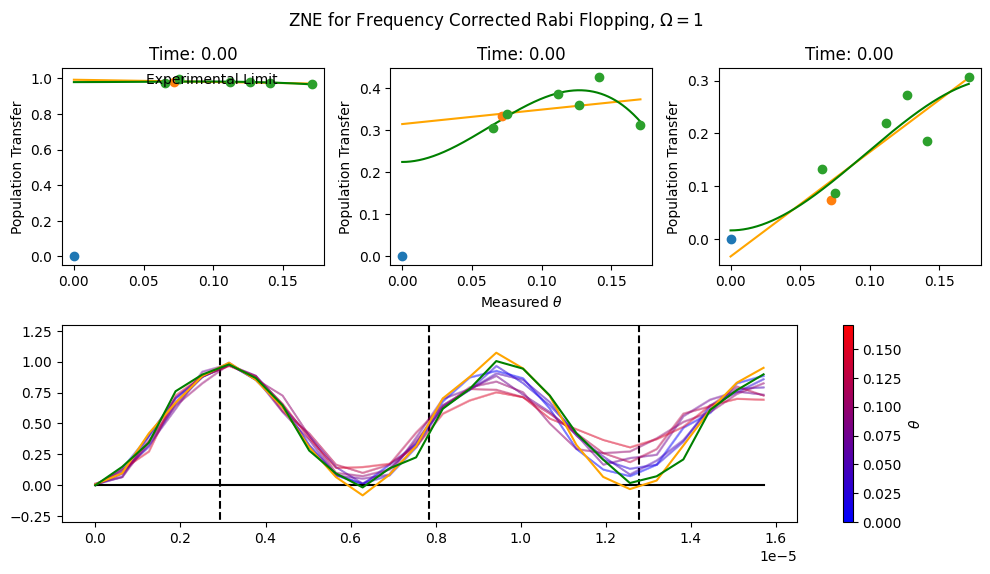

In [25]:
for qubit_index in range(len(good_qubits)):
    save_plot(qubit_index)